In [81]:
import csv 
import numpy as np
import pandas as pd
import sys
import platform
system = platform.system()
if system =='Linux':
    sys.path.append('/home/lucas/Documents/Log_Analysis/Battery')
elif system =='Darwin':
    sys.path.append('/Users/Lucas/Documents/Travail/Yuneec/LogAnalysis')
from battery import OCVcurve, Thevenin
import analog
from scipy.interpolate import interp1d as interp1d
import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook

In [82]:
path2curve = 'Battery 9 (RIP)/Discharge 200mA/SOCvsOCV_discharge200mA.csv'
curve = OCVcurve(path2curve)

Polynomial coefficients are [ 1.52788846e+04 -8.72549066e+04  2.17334010e+05 -3.10041409e+05
  2.79727730e+05 -1.66339122e+05  6.58950193e+04 -1.71764814e+04
  2.84137523e+03 -2.78910653e+02  1.48101968e+01  3.34063750e+00]


## Import the test file

### Insert here the path to the folder containing the logs you want to analyze.

In [83]:
if system == 'Linux':
    folder = '/home/lucas/Documents/Log_Analysis/Logs/KF Testing/Donald Trump/Both'
elif system == 'Darwin':
    folder = '/Users/Lucas/Documents/Travail/Yuneec/Logs/KF Testing/H3/Both'

### And change the index argument to the index of the log you want to analyze in the folder. The function `pathfromQGC` retrieves the entire log name.

In [84]:
log_file = analog.pathfromQGC(folder,index=173)

Here the dictionnary `info` containing all the different logged signals is returned by `logextract`, and the signals are then extracted from the dictionnary by their key.

In [85]:
print(log_file)
info = analog.logextract(log_file,['battery_status','battery_status_ekf','vehicle_local_position'])
print(info.keys())

# From battery_status
current = info['battery_current']
current_filtered = info['battery_filtered_current']
SOC = info['remaining']
time = info['time_bs']
time_ekf = info['time_bkf']
n_cells = info['n_cells']
voltage = info['battery_voltage']/n_cells

# From battery_status_ekf
voltage_ekf = info['voltage_ekf']/n_cells[:len(info['voltage_ekf'])]
voltage_estimate = info['voltage_estimate']
SOC_ekf = info['remaining_ekf']
kalman_gain = info['kalman_gain']
kalman_gain = np.squeeze(kalman_gain)
covar_x = info['covx']
covar_w = info['covw']
innovation = info['innovation']
iR1 = info['iR1']

# # discard timestamps with non-initalized battery
# current = current[voltage>0]
# current_filtered = current_filtered[voltage>0]
# SOC = SOC[voltage>0]
# time = time[voltage>0]
# # kalman_gain = kalman_gain[:,voltage>0]
# # covar_x = covar_x[:,:,voltage>0]
# # innovation = innovation[voltage>0]
# # iR1 = iR1[voltage>0]
# voltage = voltage[voltage>0] # to be done at the end
# print(len(time))

# # From vehicle_local_position
# x = info['x']
# y = info['y']
# z = info['z']
# time_vlp = info['time_vlp']

/home/lucas/Documents/Log_Analysis/Logs/KF Testing/Donald Trump/Both/log_173_2019-12-19-10-15-02.ulg
dict_keys(['time_vlp', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'time_bkf', 'remaining_ekf', 'voltage_estimate', 'covx', 'covw', 'kalman_gain', 'innovation', 'iR1', 'voltage_ekf', 'time_bs', 'n_cells', 'battery_current', 'battery_filtered_current', 'battery_voltage', 'battery_filtered_voltage', 'discharged_mah', 'remaining'])


# Kalman filter analysis

## Example of a simple plot
In order to illustrate how to make a very simple time plot using the signals extracted in the previous cell, here is the example of current plot. Caution : as signals come from two different topics (`battery_status` and `battery_status_ekf`) it is important to use the correspoding time series, respectively `time` and `time_ekf` when making a time plot of a signal. The origin of each signal is made clear in the preivous cell thanks to the split in two paragraphs.

<IPython.core.display.Javascript object>


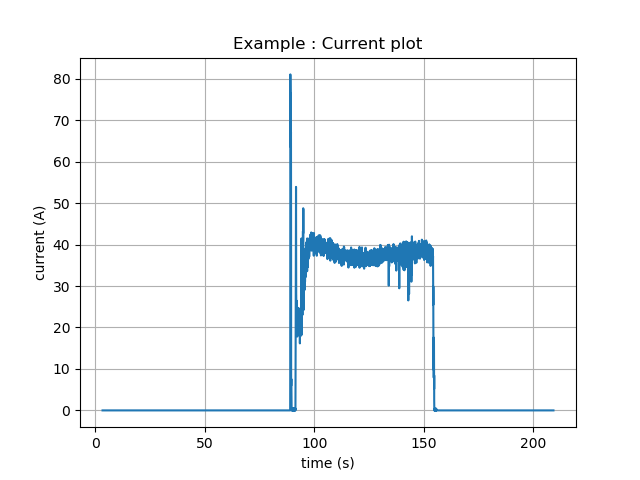

Text(0.5, 1.0, 'Example : Current plot')

In [86]:
plt.figure()
plt.plot(time, current)
plt.xlabel('time (s)')
plt.ylabel('current (A)')
plt.grid()
plt.title('Example : Current plot')

## Estimators comparison
The  next plot is probably the most important plot of the notebook. It constist of a comparison between the SOC given by the legacy estimator and the EKF one. The horizontal red lines indicate the bounds for a meaningful state of charge, that are actually implemented in the firmware. At these bounds, the SOC will saturate (be constrained to these value), incating that something is wrong with the state estimate.

<IPython.core.display.Javascript object>


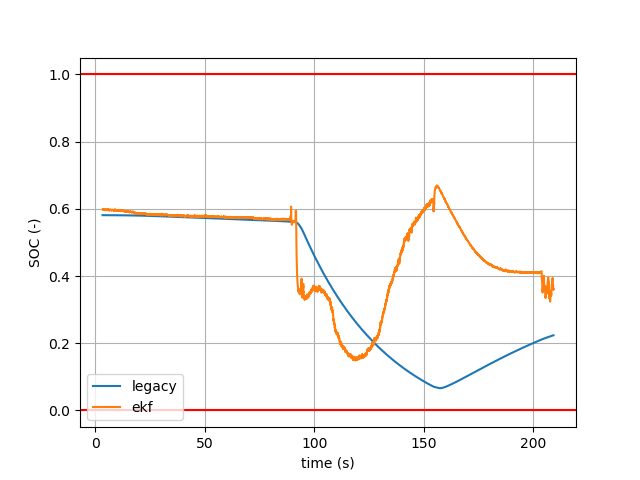

In [102]:
%matplotlib notebook
plt.figure()
plt.plot(time,SOC,label='legacy') # using time because SOC comes from battery_status
plt.plot(time_ekf,SOC_ekf,label='ekf') #using time_ekf because SOC_ekf comes from battery_status_ekf
#plt.plot(time_ekf,SOC_ekf + 3*np.sqrt(covar_x[0,0,:]),linestyle=':',color='C1')
#plt.plot(time_ekf,SOC_ekf - 3*np.sqrt(covar_x[0,0,:]),linestyle=':',color='C1')
#plt.plot(time,voltage/4.35,alpha=0.5)
plt.xlabel('time (s)')
plt.ylabel('SOC (-)')
plt.axhline(0,color='r')
plt.axhline(1,color='r')
#plt.plot(time,current/current[0],alpha=.7)
plt.grid()
plt.legend(loc='lower left')
plt.show()

# Simulation
 In the following section, a simulation of the EKF-based SOC estimator is performed based on the same current and voltage signals contained in the log. The difference is that the equivalent circuit parameters such as R0, R1 and C1 as well as the EKF parameters such as covw, covv and covx0 can be modified as much as desired. The outputs of the simulated estimation (i.e. the estimated SOC, the estimated voltage and the innovation it would yield, or the Kalman gain) can therefore be observed without flashing the drone with the new parameters every time.
 
Results are much better if the log analyzed is : 
- logged from boot
- `battery_status` and `battery_status_ekf` logging at full rate

In [116]:
# Equivalent circuit parameters

# from csv 
ECparams = pd.read_csv('ECparams.csv')
R0 = float(ECparams['R0'])
R1 = float(ECparams['R1'])
C1 = float(ECparams['C1'])

# or manually
R0 = 0.015
R1 = 0.01
C1 = 700 
print([R0,R1,C1])

[0.015, 0.01, 700]


### Tune some more simulation parameters

In [106]:
Q = 6500*3.6 # has to be in Coulombs
eta = 1 # charging efficiency, not relevant im our case because the battery is continuously discharging 
z0 = SOC_ekf[0] # initialize the simulated SOC at the same point as the logged one
print(f'z0 = {z0}')
battery = Thevenin(z0,Q,curve,R0,R1,C1)

z0 = 0.5983168482780457


### Run the simulation using the state-space model
Here is where the parameters specific to the usage of a Kalman Filter can be tuned.

In [113]:
xhat0 = np.array([[SOC[0]],[iR1[0]]]) # is a stack of 2x1 arrays = a 2xk array
covx0 = covar_x[:,:,0]
print(f'covx0 = {covx0}')
covx0 = np.array([[1e-3,0.],[0., 0.01]]) # is a stack of 2x2 arrays

covw = np.array([[1e-4, 0.],[0., 1e-5]]) # is a constant 2x2 array
covw = np.array([[1e-8, 0.],[0., 1e-8]]) # is a constant 2x2 array
#covw = covar_w[:,:,0]
print(f' covw = {covw}')
step=1
u = current[slice(1,len(current),step)] # is a stack of 1x1 arrays = a 1-D array
y = voltage[slice(1,len(voltage),step)] # is a stack of 1x1 arrays = a 1-D array

kfbat = Thevenin(z0,Q,curve,R0,R1,C1)

covx0 = [[0.10799953 0.01748072]
 [0.01748072 1.6396542 ]]
 covw = [[1.e-08 0.e+00]
 [0.e+00 1.e-08]]


In [117]:
# Perform simulation
xhat,covx,yhat,L = kfbat.kfrun(time_ekf,u,y,covw=covw,covx0=covx0,alpha=0.9)

## Comparison of simulated python  KF results with firmware ones
This section aims at comparing the simulation results with the ones obtained by the EKF runnig in the firmware. Both are obtained with the same current and voltage, since the simulation is realized with the log. 

In theory, if the parameters used for the simulation are the same as in the firmware, the outputs should be the same. However, difference will subsist if the log is not from boot or if the battery-related topics are not logged at full rate. _Please check this two important aspects first, before modifying the simulation code !_

<IPython.core.display.Javascript object>


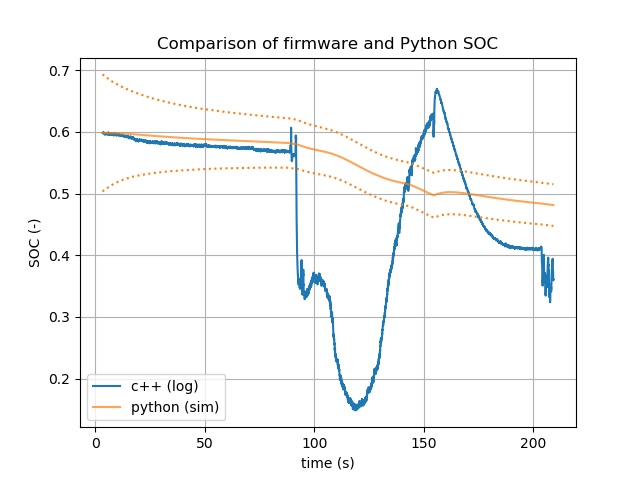

In [118]:
n=len(time)
plt.figure()
plt.plot(time_ekf,SOC_ekf,label='c++ (log)')
#plt.plot(time_ekf,SOC_ekf+3*np.sqrt(covar_x[0,0,:]),linestyle=':',color='C0')
#plt.plot(time_ekf,SOC_ekf-3*np.sqrt(covar_x[0,0,:]),linestyle=':',color='C0')
plt.plot(time[slice(0,n-1,step)],xhat[0,:],alpha=0.7,label='python (sim)')
plt.plot(time[slice(0,n-1,step)],xhat[0,:]+3*np.sqrt(covx[0,0,:]),linestyle=':',color='C1')
plt.plot(time[slice(0,n-1,step)],xhat[0,:]-3*np.sqrt(covx[0,0,:]),linestyle=':',color='C1')
plt.xlabel('time (s)')
plt.ylabel('SOC (-)')
plt.legend()
plt.grid()
plt.title('Comparison of firmware and Python SOC')
plt.show()

### Meaningful errors when tuning the EC parameters

In [119]:
print(xhat[0,0])
print(np.max(xhat[0,:]))
print(f'Err max : {np.max(xhat[0,:]) - xhat[0,0]}')

0.5983168482780457
0.5983168482780457
Err max : 0.0


In [109]:
print(np.min(xhat[0,:]))
print(xhat[0,-1])
print(f'Err min : {xhat[0,0] - np.min(xhat[0,:])}')

0.4804281837535689
0.4804281837535689
Err min : 0.11788866452447677


<IPython.core.display.Javascript object>


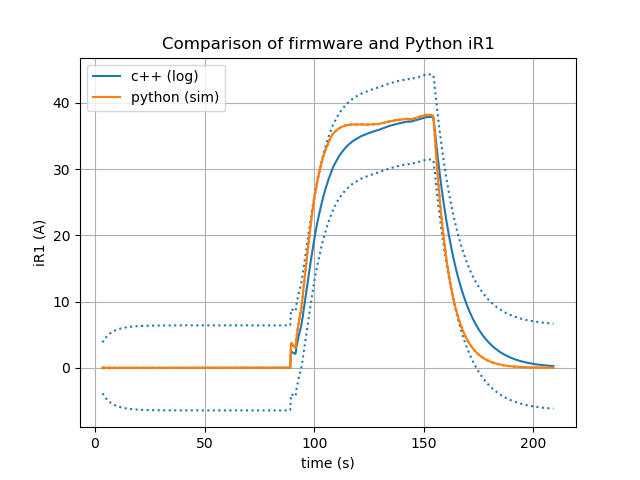

In [101]:
plt.figure()
plt.plot(time_ekf,iR1,label='c++ (log)')
plt.plot(time_ekf,iR1+3*np.sqrt(covar_x[1,1,:]),linestyle=':',color='C0')
plt.plot(time_ekf,iR1-3*np.sqrt(covar_x[1,1,:]),linestyle=':',color='C0')
plt.plot(time_ekf[slice(0,n-1,step)],xhat[1,:],label='python (sim)')
plt.plot(time_ekf[slice(0,n-1,step)],xhat[1,:]+np.sqrt(covx[1,1,:]),linestyle=':',color='C1')
plt.plot(time_ekf[slice(0,n-1,step)],xhat[1,:]-np.sqrt(covx[1,1,:]),linestyle=':',color='C1')
plt.xlabel('time (s)')
plt.ylabel('iR1 (A)')
plt.legend()
plt.title('Comparison of firmware and Python iR1')
plt.grid()

<IPython.core.display.Javascript object>


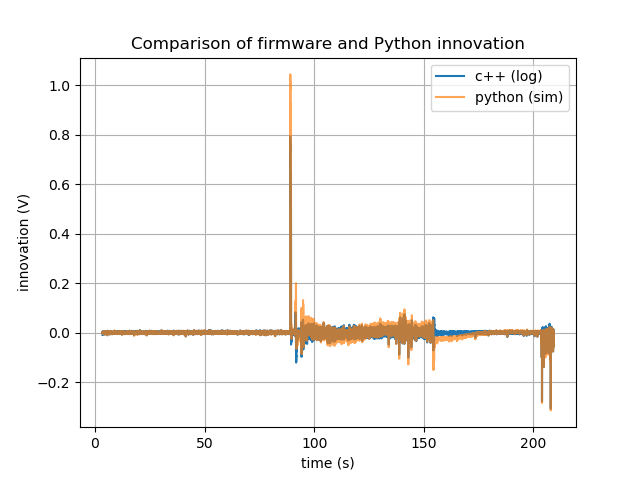

In [41]:
plt.figure()
plt.plot(time_ekf,innovation,label='c++ (log)')
plt.plot(time_ekf[slice(1,n,step)],y[slice(1,n,step)]-yhat[slice(1,n,step)],label='python (sim)',alpha=0.7)
plt.xlabel('time (s)')
plt.ylabel('innovation (V)')
plt.legend()
plt.grid()
plt.title('Comparison of firmware and Python innovation')
plt.show()

<IPython.core.display.Javascript object>


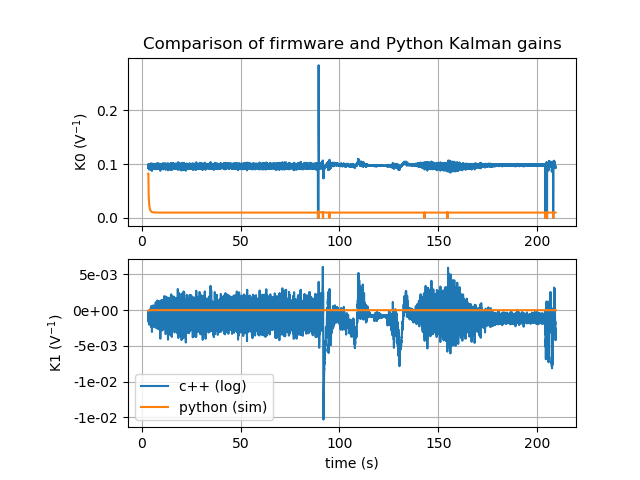

In [64]:
import matplotlib.ticker as mtick

fig = plt.figure()
plt.subplot(211)
plt.plot(time_ekf,kalman_gain[0,:],label='c++ (log)')
plt.plot(time[slice(1,n,step)],L[0,:],label='python (sim)')
plt.grid()
plt.ylabel('K0 (V$^{-1}$)')
plt.title('Comparison of firmware and Python Kalman gains')

ax = plt.subplot(212)
plt.plot(time_ekf,kalman_gain[1,:],label='c++ (log)')
plt.plot(time[slice(1,n,step)],L[1,:],label='python (sim)')
plt.xlabel('time (s)')
plt.ylabel('K1 (V$^{-1}$)')
plt.gcf().subplots_adjust(left=0.2)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))
plt.legend()
plt.grid()
plt.show()


It is totally normal to see the Kalman gain stabilize around some value.

<IPython.core.display.Javascript object>


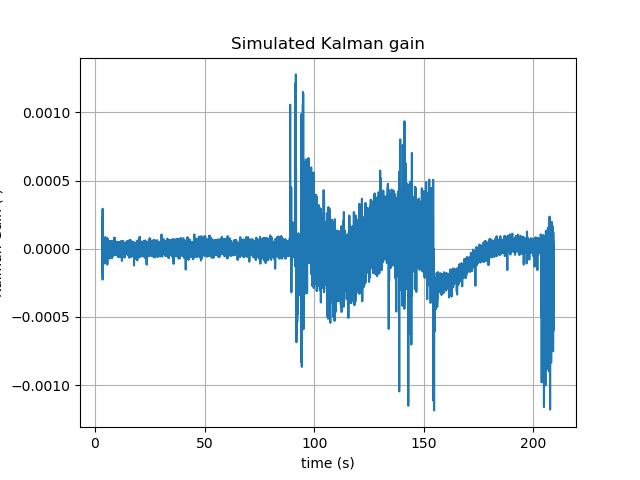

Text(0.5, 1.0, 'Simulated Kalman gain')

In [40]:
plt.figure()
plt.plot(time_ekf[slice(1,n,step)],L[0,slice(1,n,step)]*(y[slice(1,n,step)]-yhat[slice(1,n,step)]))
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Kalman Gain (-)')
plt.title('Simulated Kalman gain')

## Sensor fault detection based on Chi-square test 
Here for every point of NEES that is above the red cutoff line, the Kalman gain is set to zero so that the measurement has no impact on the state estimate. The alpha parameter that defines the cutoff level for the sensor fault detection should be set so that points that look like sensor faults, as well as the startup current spikes are discarded.

<IPython.core.display.Javascript object>


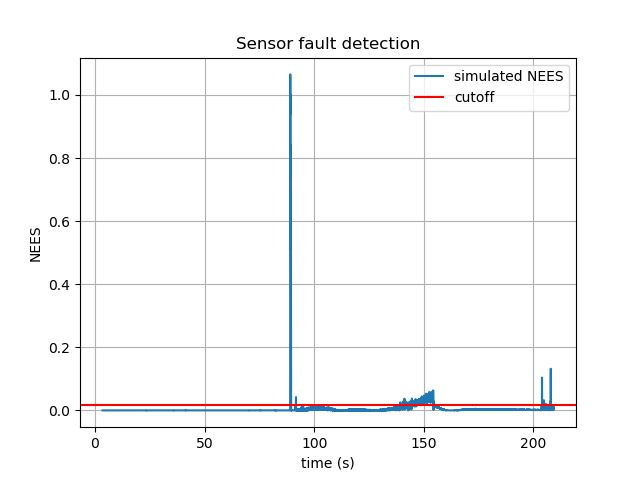

Cutoff value: 0.01579077409343121


In [120]:
covy = kfbat.C@kfbat.covx@kfbat.C.T + kfbat.covv
nees = np.squeeze((y[slice(1,n,step)]-yhat[slice(1,n,step)])*1/covy*(y[slice(1,n,step)]-yhat[slice(1,n,step)]))
plt.figure()
plt.plot(time_ekf[slice(1,n,step)],nees,label='simulated NEES')
plt.axhline(kfbat.chisquare,color='r',label='cutoff')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('NEES')
plt.legend()
plt.title('Sensor fault detection')
print(f'Cutoff value: {kfbat.chisquare}')